## Installing and Importing Libraries

In [1]:
#!pip install keract

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

## Importing Dataset and Data Pre-Processing

In [3]:
data_dir = "../data/OCT2017/"
train_data_dir= '../data/OCT2017/train/'
val_data_dir= '../data/OCT2017/val/'
test_data_dir= '../data/OCT2017/test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

In [4]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values())
print('cnv ', cnv_images, '\ndme ', dme_images,'\ndrusen ', drusen_images,'\nnormal ', normal_images)
print('total :', cnv_images+dme_images+drusen_images+normal_images)

cnv  37205 
dme  11348 
drusen  8616 
normal  26315
total : 83484


### Keras Data Generators

In [5]:
# instanciation de generateurs de données d'entrainement et de test
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [6]:
# génération de jeux de données d'entrainement et de test
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [7]:
# encodage des catégories
num_classes = len(train_generator.class_indices)  

train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

In [8]:
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print('train set :', nb_train_samples,'\nvalidation set :', nb_valid_samples, '\ntest set :', nb_test_samples)

train set : 83484 
validation set : 32 
test set : 968


## Model

### Transfert learning

* VGG16 CNN architecture is used for classification.
* Pretrained on the 'ImageNet' dataset.

In [9]:
# instanciation d'un model VGG16 avec pré-entrainement imagenet
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
# creation du model avec transfert learning de vgg16 et ajout de couches de sortie
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

# Ajout de la couche de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de la couche d'aplatissement
model.add(Flatten())

# Ajout de la couche entièrement connectée
model.add(Dense(4096, activation='relu'))

# Ajout de la couche de dropout
model.add(Dropout(0.5))

# Ajout de la deuxième couche entièrement connectée
model.add(Dense(4096, activation='relu'))

# Ajout de la deuxième couche de dropout
model.add(Dropout(0.2))

# Ajout de la couche de sortie
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

### Baseline Model Training

In [11]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate= 0.001), 
    loss='categorical_crossentropy', 
    metrics= ['accuracy']
    )

In [12]:
# définition des hyperparamètres du model
numepochs = 5
batch_size = 64
model_name='vgg16_e5b64_5'
checkpoint_filepath = model_name+'/tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
callbacks_list = [earlystop,checkpoint]

In [13]:
xrange = range
files_per_class = []
for folder in os.listdir(train_data_dir):
    if not os.path.isfile(folder):
            files_per_class.append(len(os.listdir(train_data_dir + '/' + folder)))
total_files = sum(files_per_class)
class_weights = {}
for i in xrange(len(files_per_class)):
    class_weights[i] = 1 - (float(files_per_class[i]) / total_files)
print (class_weights)

{0: 0.5543457428968426, 1: 0.8640697618705381, 2: 0.8967945953715682, 3: 0.6847898998610512}


In [14]:
# entrainement epoch 5 et batch 128
history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list,
                        class_weight=class_weights
                        )


Epoch 1/5
2609/2609 [==============================] - 7881s 3s/step - loss: 0.4948 - accuracy: 0.7549 - val_loss: 0.4483 - val_accuracy: 0.9062
Epoch 2/5
2609/2609 [==============================] - 7890s 3s/step - loss: 0.4206 - accuracy: 0.7915 - val_loss: 0.4591 - val_accuracy: 0.8438
Epoch 3/5
2609/2609 [==============================] - 7725s 3s/step - loss: 0.3993 - accuracy: 0.8034 - val_loss: 0.3632 - val_accuracy: 0.9062
Epoch 4/5
2609/2609 [==============================] - 7950s 3s/step - loss: 0.3927 - accuracy: 0.8089 - val_loss: 0.4698 - val_accuracy: 0.9062
Epoch 4: early stopping


### Evaluations on Test Dataset

In [15]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 84s 3s/step - loss: 0.5113 - accuracy: 0.8502
Test Loss:  0.5113028883934021
Test Accuracy:  0.8502066135406494


In [17]:
if not os.path.exists(model_name+'/img'):
   os.makedirs(model_name+'/img')

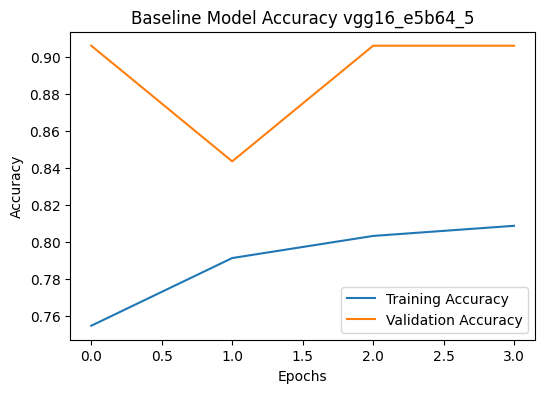

In [18]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title(f'Baseline Model Accuracy {model_name}')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig(model_name+'/img/baseline_acc_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

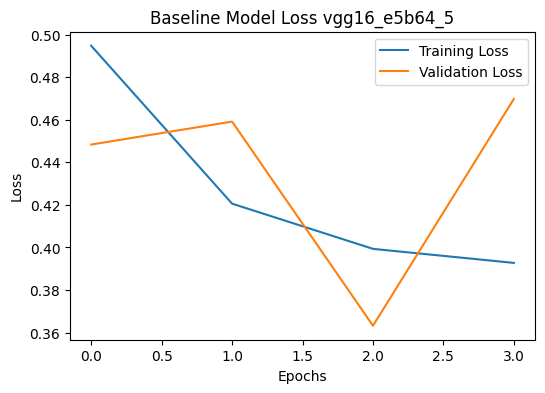

In [19]:
plt.subplot()
plt.title(f'Baseline Model Loss {model_name}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig(model_name+'/img/baseline_loss_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

31/31 [==============================] - 82s 3s/step


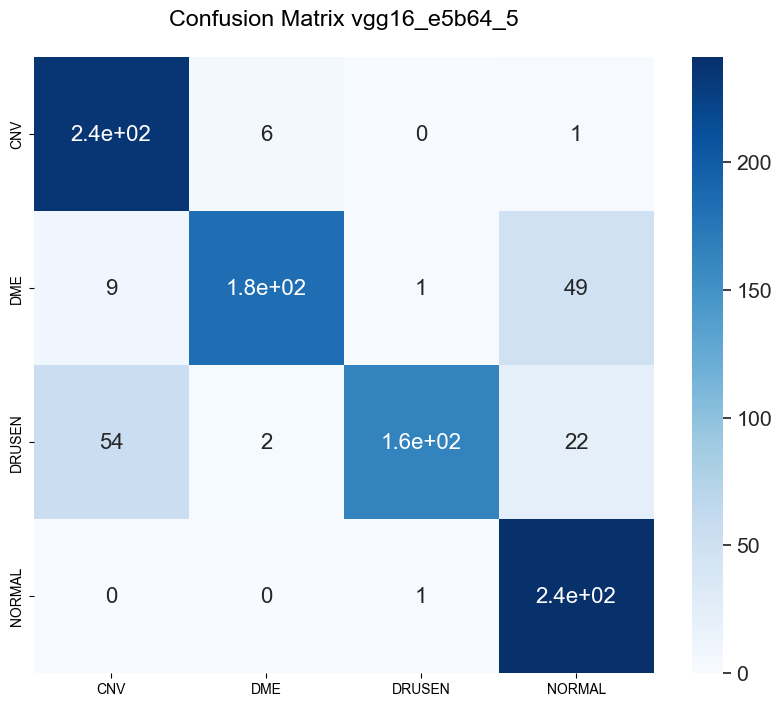

In [20]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix {model_name}\n')
plt.savefig(model_name+'/img/confusion_matrix_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [21]:
print(f'Classification Report {model_name}\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report vgg16_e5b64_5

              precision    recall  f1-score   support

         CNV       0.79      0.97      0.87       242
         DME       0.96      0.76      0.85       242
      DRUSEN       0.99      0.68      0.80       242
      NORMAL       0.77      1.00      0.87       242

    accuracy                           0.85       968
   macro avg       0.88      0.85      0.85       968
weighted avg       0.88      0.85      0.85       968



### Save the model

In [22]:
model_save_h5 = model_name+"/retinal_oct_model_"+model_name+".h5"
model_save_json = model_name+"/retinal_oct_model_"+model_name+".json"
model_save_weights = model_name+"/retinal_oct_model_"+model_name+"_weights.h5"
model_save_metrics = model_name+"/retinal_oct_model_"+model_name+"_eval.json"

In [23]:
# save model and architecture to h5 file
model.save(model_save_h5)
print("Saved h5 model to disk")

Saved h5 model to disk


In [24]:
#save the model architecture to JSON file
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
with open(model_save_json, 'w') as json_file:
    json_file.write(json_model)
print("Saved json model to disk")

Saved json model to disk


In [25]:
#saving the weights of the model
model.save_weights(model_save_weights)
print("Saved model weights to disk")

Saved model weights to disk


In [26]:
import json
# save model metrics
json_model_eval = {}
json_model_eval["model_name"]=model_name
json_model_eval["loss"] = eval_loss
json_model_eval["accuracy"] = eval_accuracy
with open(model_save_metrics, 'w') as json_file:
    json_file.write(str(json_model_eval))
print("Saved model metrics to disk")

Saved model metrics to disk
